In [1]:
from pathlib import Path

import alphashape as alph
from alphashape.optimizealpha import _testalpha

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Patch

import numpy as np
import pandas as pd
import scipy
import shapely
from descartes import PolygonPatch
from sklearn.cluster import DBSCAN, KMeans

data_dir = Path("/Users/henrywilde/papers/edo/data/kmeans_over_dbscan/0/summary/")
img_dir = Path("/Users/henrywilde/posters/siam-ukie/img/")
seed = 0

In [8]:
def _optimise_alpha(points, max_iter=100, tol=1e-4, upper=1000):
    """ Bisection optimisation. """

    points = shapely.geometry.MultiPoint(points)
    lower = 0
    itr = 0
    while (upper - lower) > tol and itr < max_iter:

        itr += 1
        test = (upper + lower) / 2

        if _testalpha(points, test):
            lower = test
        else:
            upper = test

    return lower

def convexity_scatterplot_kmeans():
    """ Create a scatter for the best, median and worst individuals in the
    trial. Also illustrate the concave and convex hulls of the k-means
    clustering of those individuals. """

    order = ["best", "worst"]

    for case, name in zip(("min", "max"), order):

        _, ax = plt.subplots(figsize=(4, 4), dpi=300)
        dataframe = pd.read_csv(data_dir / f"{case}/main.csv")
        km = KMeans(n_clusters=3, random_state=seed).fit(dataframe)

        scatter = ax.scatter(
            dataframe["0"],
            dataframe["1"],
            s=50,
            c=km.labels_,
            edgecolors="k",
            lw=0.5,
            zorder=2,
        )

        patches = []
        for label in set(km.labels_):
            try:
                mask = km.labels_ == label
                X = dataframe.values[mask, :]
                convex = scipy.spatial.ConvexHull(X)
                for simplex in convex.simplices:
                    ax.plot(
                        X[simplex, 0], X[simplex, 1], "k-", lw=1, zorder=1
                    )

                alpha = _optimise_alpha(X)
                concave = alph.alphashape(X, alpha)
                convex = shapely.geometry.Polygon(X[convex.vertices, :])

                patches.append(PolygonPatch(concave))

            except scipy.spatial.qhull.QhullError:
                pass

        collection = PatchCollection(patches, zorder=0, alpha=0.3)
        ax.add_collection(collection)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.tight_layout()
        plt.savefig(img_dir / f"kmeans_{name}.pdf", transparent=True)

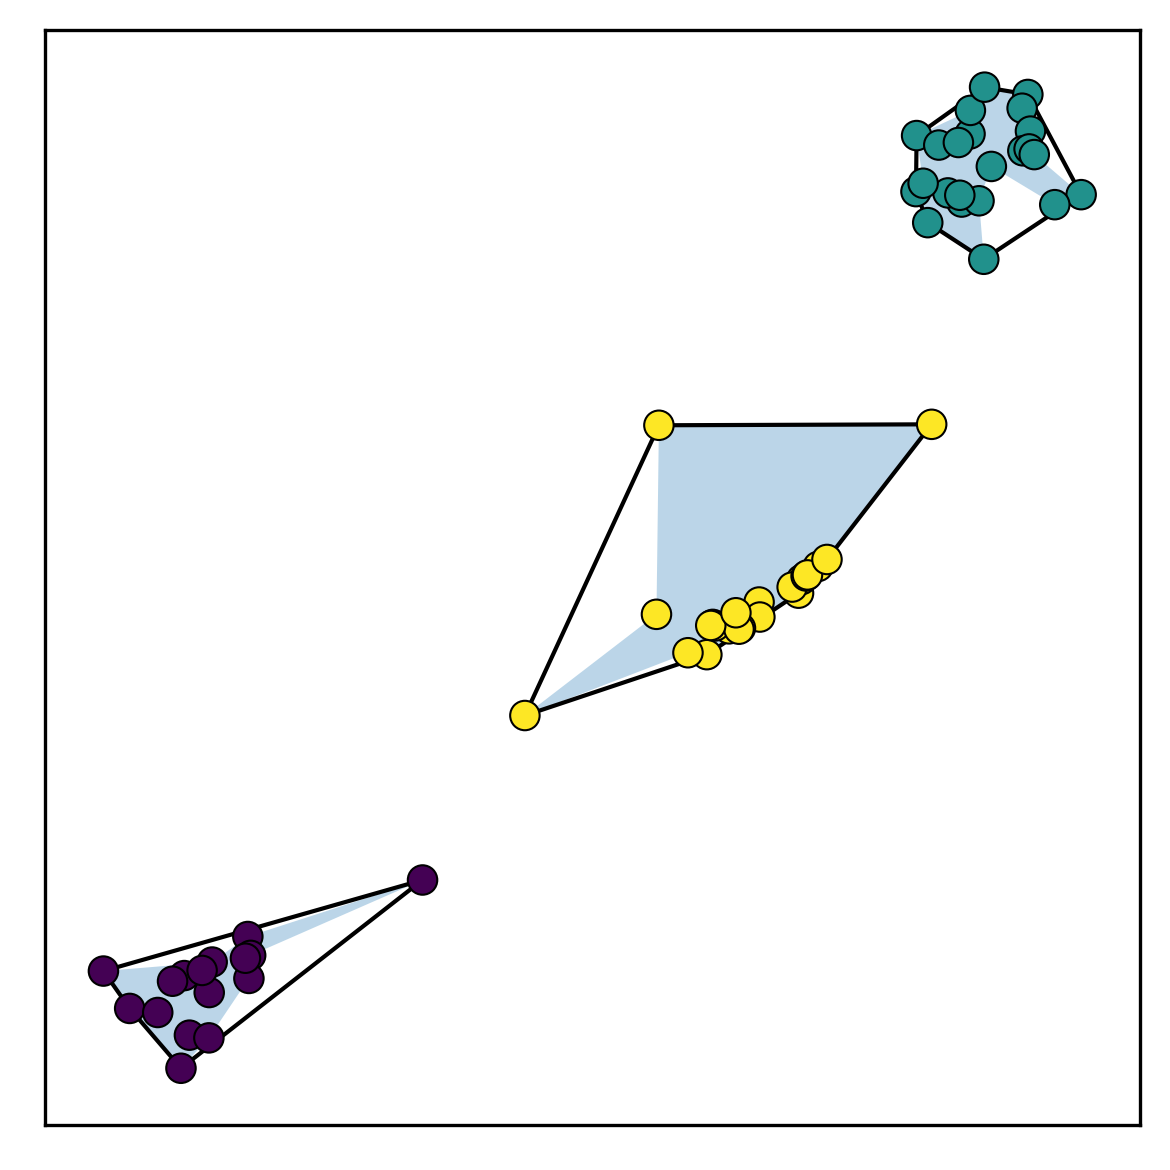

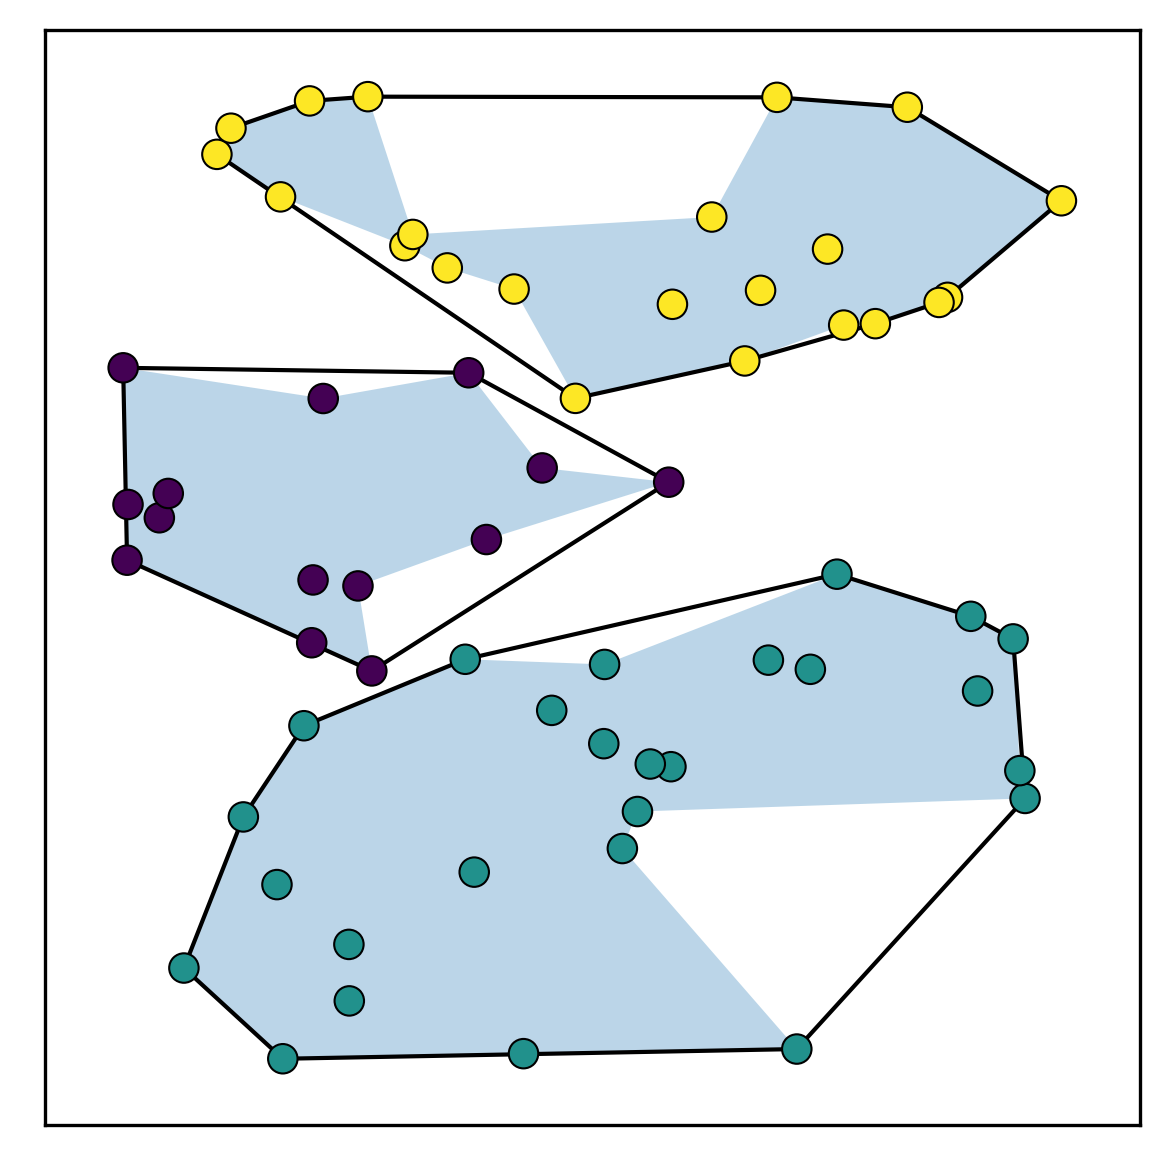

In [9]:
convexity_scatterplot_kmeans()

In [10]:
def convexity_scatterplot_dbscan():
    """ Create a scatter for the best, median and worst individuals in the
    trial. Also illustrate the concave and convex hulls of the DBSCAN
    clustering of those individuals. """

    order = ["best", "worst"]

    for case, name in zip(("min", "max"), order):

        _, ax = plt.subplots(figsize=(4, 4), dpi=300)
        dataframe = pd.read_csv(data_dir / f"{case}/main.csv")
        db = DBSCAN(eps=0.1, min_samples=5).fit(dataframe)

        outlier_mask = db.labels_ == -1
        X = dataframe.values[outlier_mask, :]
        ax.scatter(
            X[:, 0], X[:, 1], c="k", edgecolors="k", s=10, lw=0.5, zorder=2
        )

        X = dataframe.values[~outlier_mask, :]
        scatter = ax.scatter(
            X[:, 0],
            X[:, 1],
            s=50,
            c=db.labels_[~outlier_mask],
            edgecolors="k",
            lw=0.5,
            zorder=2,
        )

        patches = []
        for label in set(db.labels_):
            if label != -1:
                try:
                    mask = db.labels_ == label
                    X = dataframe.values[mask, :]
                    convex = scipy.spatial.ConvexHull(X)
                    for simplex in convex.simplices:
                        ax.plot(
                            X[simplex, 0], X[simplex, 1], "k-", lw=1, zorder=1
                        )

                    alpha = _optimise_alpha(X)
                    concave = alph.alphashape(X, alpha)

                    convex = shapely.geometry.Polygon(X[convex.vertices, :])
                    intersection = convex.intersection(concave)

                    patches.append(PolygonPatch(concave))

                except scipy.spatial.qhull.QhullError:
                    pass

        collection = plt.matplotlib.collections.PatchCollection(
            patches, zorder=0, alpha=0.3
        )
        ax.add_collection(collection)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.tight_layout()
        plt.savefig(img_dir / f"dbscan_{name}.pdf", transparent=True)

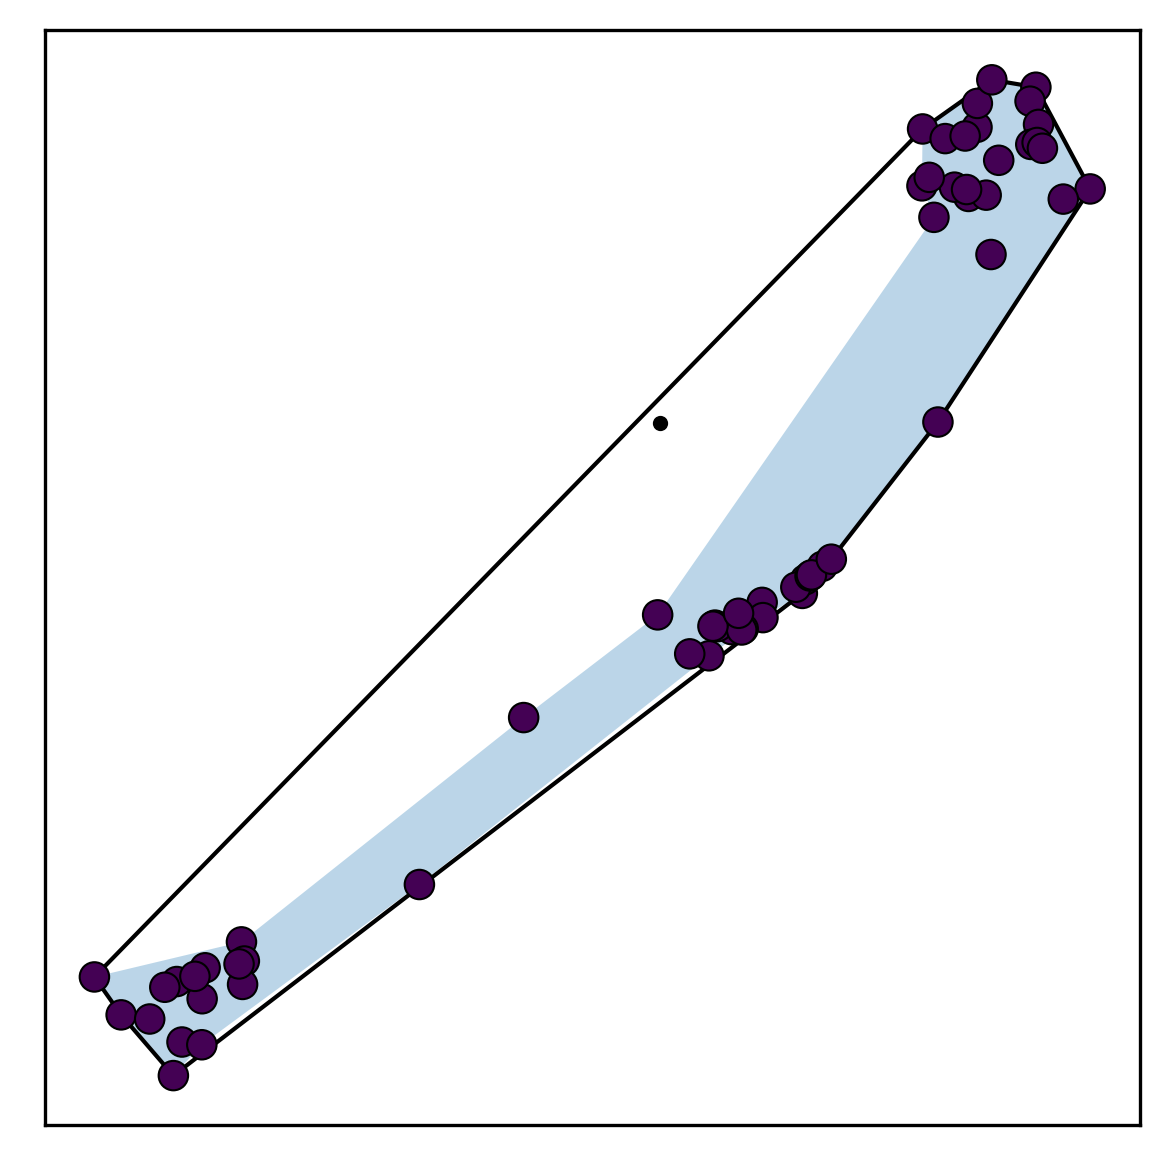

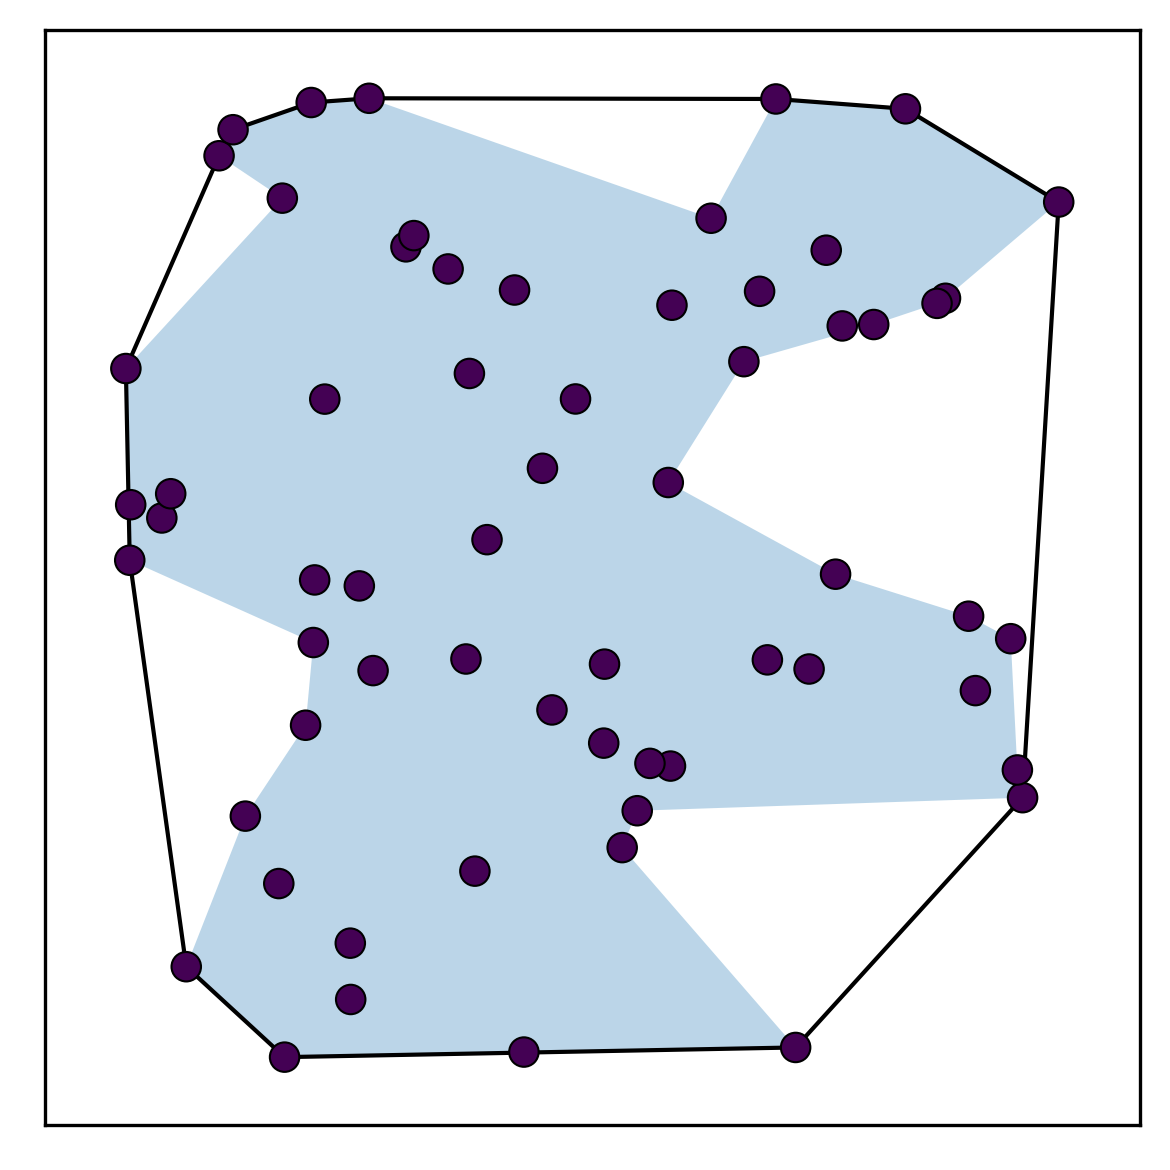

In [11]:
convexity_scatterplot_dbscan()